In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import gc
import keras.backend as K
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical  
from PIL import Image
import random

Using TensorFlow backend.


In [2]:
from __future__ import division, print_function
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from keras.layers import BatchNormalization,Reshape,Permute,Activation,Input 
from keras.layers import Concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2DTranspose
from keras.layers import Cropping2D
from keras.layers import Lambda, Activation, Dropout

In [3]:
BATCH_SIZE = 4

In [4]:
# all_imgs = os.listdir('D:/kaggle/nongye/jingwei_round1_train_20190619/train')
# random.shuffle(all_imgs)
# num_imgs = len(all_imgs)
# num_train_imgs = 4 * num_imgs // 5
# train_imgs = all_imgs[:num_train_imgs]
# val_imgs = all_imgs[num_train_imgs:]

In [5]:
file = open("D:/kaggle/nongye/jingwei_round1_train_20190619/train_img_list.txt",'r')
a = file.read()
train_imgs = eval(a)
file.close()

In [6]:
file = open("D:/kaggle/nongye/jingwei_round1_train_20190619/val_img_list.txt",'r')
a = file.read()
val_imgs = eval(a)
file.close()

del(file, a)
gc.collect()

7

In [7]:
num_train_imgs = len(train_imgs)
num_val_imgs = len(val_imgs)

In [8]:
import random
random.shuffle(train_imgs)

In [9]:
num_train_imgs // BATCH_SIZE * 4

8856

In [10]:
num_val_imgs // BATCH_SIZE * 4

2212

In [11]:
def make_image_gen(origin, batch_size=BATCH_SIZE): 
    i = 0
    out_rgb = []
    out_mask = []
    all_imgs = train_imgs if origin=='train' else val_imgs
    num_imgs = 8856 if origin=='train' else 2212
    while True:
        if i >= num_imgs: i=0
        img_name = all_imgs[i]
        i += 1
        img = imread('D:/kaggle/nongye/jingwei_round1_train_20190619/train/' + img_name, plugin='matplotlib')
        mask = imread('D:/kaggle/nongye/jingwei_round1_train_20190619/label/' + img_name, plugin='matplotlib')
        mask = to_categorical(mask, num_classes=4) 
        out_rgb += [img]
        out_mask += [mask]
        if len(out_rgb) >= batch_size:
            yield np.stack(out_rgb, 0), np.stack(out_mask, 0)
            out_rgb, out_mask = [], []

In [12]:
# train_gen = make_image_gen('val')
# train_x, train_y = next(train_gen)
# print('x', train_x.shape, train_x.min(), train_x.max())
# print('y', train_y.shape, train_y.min(), train_y.max())

In [13]:
# VALID_IMG_COUNT = 200

In [14]:
# valid_x, valid_y = next(make_image_gen(VALID_IMG_COUNT))
# print(valid_x.shape, valid_y.shape)

In [15]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 45, 
               horizontal_flip = True, 
               vertical_flip = True,
               fill_mode = 'reflect',
               data_format = 'channels_last',
               width_shift_range = 0.15, 
               height_shift_range = 0.15, 
               shear_range = 0.01,
               zoom_range = [0.8, 1.4])

In [16]:
image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

val_img_gen = ImageDataGenerator()
val_lab_gen = ImageDataGenerator()

In [17]:
def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x) / 255, next(g_y)

In [18]:
def create_val_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = val_img_gen.flow(in_x, 
                              batch_size = in_x.shape[0], 
                              seed = seed, 
                              shuffle=True)
        g_y = val_lab_gen.flow(in_y, 
                               batch_size = in_x.shape[0], 
                               seed = seed, 
                               shuffle=True)

        yield next(g_x) / 255, next(g_y)

In [19]:
# %%time
# cur_gen = create_aug_gen(train_gen)
# t_x, t_y = next(cur_gen)
# print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
# print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

In [20]:
# %%time
# cur_val_gen = create_val_gen(train_gen)
# t_x, t_y = next(cur_gen)
# print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
# print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

In [21]:
def downsampling_block(input_tensor, filters, padding='valid',  #下采样部分
                       batchnorm=False, dropout=0.0):
    _, height, width, _ = K.int_shape(input_tensor)
#     assert height % 2 == 0
#     assert width % 2 == 0

    x = Conv2D(filters, kernel_size=(3,3), padding=padding)(input_tensor)
    x = BatchNormalization()(x) if batchnorm else x
    x = Activation('relu')(x)
    x = Dropout(dropout)(x) if dropout > 0 else x

    x = Conv2D(filters, kernel_size=(3,3), padding=padding)(x)
    x = BatchNormalization()(x) if batchnorm else x
    x = Activation('relu')(x)
    x = Dropout(dropout)(x) if dropout > 0 else x

    return MaxPooling2D(pool_size=(2,2))(x), x   #返回的是池化后的值和dropout后的值，这里dropout后的值用于上采样特征级联

def upsampling_block(input_tensor, skip_tensor, filters, padding='valid',
                     batchnorm=False, dropout=0.0):    #下采样部分
    x = Conv2DTranspose(filters, kernel_size=(2,2), strides=(2,2))(input_tensor)
    _, x_height, x_width, _ = K.int_shape(x)
    _, s_height, s_width, _ = K.int_shape(skip_tensor)
    h_crop = s_height - x_height
    w_crop = s_width - x_width
    assert h_crop >= 0
    assert w_crop >= 0
    if h_crop == 0 and w_crop == 0:
        y = skip_tensor
    else:                       #使级联时像素大小一致
        cropping = ((h_crop//2, h_crop - h_crop//2), (w_crop//2, w_crop - w_crop//2))
        y = Cropping2D(cropping=cropping)(skip_tensor)

    x = Concatenate()([x, y])         #特征级联

    x = Conv2D(filters, kernel_size=(3,3), padding=padding)(x)
    x = BatchNormalization()(x) if batchnorm else x
    x = Activation('relu')(x)
    x = Dropout(dropout)(x) if dropout > 0 else x

    x = Conv2D(filters, kernel_size=(3,3), padding=padding)(x)
    x = BatchNormalization()(x) if batchnorm else x
    x = Activation('relu')(x)
    x = Dropout(dropout)(x) if dropout > 0 else x

    return x                   #返回dropout后的值

def unet(height, width, channels, classes, features=64, depth=4,
         temperature=1.0, padding='valid', batchnorm=False, dropout=0.0):  #使用4个深度长的网络就是官网的典型网络
    x = Input(shape=(height, width, channels))
    inputs = x

    skips = []                   #用于存放下采样中，每个深度后，dropout后的值，以供之后级联使用
    for i in range(depth):
        x, x0 = downsampling_block(x, features, padding,
                                   batchnorm, dropout)
        skips.append(x0)
        features *= 2            #下采样过程中，每个深度往下，特征翻倍，即每次使用翻倍数目的滤波器

    x = Conv2D(filters=features, kernel_size=(3,3), padding=padding)(x)
    x = BatchNormalization()(x) if batchnorm else x
    x = Activation('relu')(x)
    x = Dropout(dropout)(x) if dropout > 0 else x

    x = Conv2D(filters=features, kernel_size=(3,3), padding=padding)(x)
    x = BatchNormalization()(x) if batchnorm else x
    x = Activation('relu')(x)
    x = Dropout(dropout)(x) if dropout > 0 else x

    for i in reversed(range(depth)):    #下采样过程中，深度从深到浅
        features //= 2                  #每个深度往上。特征减少一倍
        x = upsampling_block(x, skips[i], features, padding,
                             batchnorm, dropout)

    x = Conv2D(filters=classes, kernel_size=(1,1))(x)

    logits = Lambda(lambda z: z/temperature)(x)      #简单的对x做一个变换
    probabilities = Activation('softmax')(logits)    #对输出的两类做softmax，转换为概率。形式如【0.1,0.9],则预测为第二类的概率更大。

    return Model(inputs=inputs, outputs=probabilities)

In [22]:
model = unet(768, 768, 3, 4, features=8, depth=4, padding='same', batchnorm=True, dropout=0.1)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# def unet(img_w, img_h, channels, n_label):
#     inputs = Input((img_w, img_h, channels))
 
#     conv1 = Conv2D(8, (3, 3), activation="relu", padding="same")(inputs)
#     conv1 = Conv2D(8, (3, 3), activation="relu", padding="same")(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
 
#     conv2 = Conv2D(16, (3, 3), activation="relu", padding="same")(pool1)
#     conv2 = Conv2D(16, (3, 3), activation="relu", padding="same")(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
 
#     conv3 = Conv2D(32, (3, 3), activation="relu", padding="same")(pool2)
#     conv3 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
 
#     conv4 = Conv2D(64, (3, 3), activation="relu", padding="same")(pool3)
#     conv4 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
#     conv5 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool4)
#     conv5 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv5)
 
#     up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
#     conv6 = Conv2D(64, (3, 3), activation="relu", padding="same")(up6)
#     conv6 = Conv2D(63, (3, 3), activation="relu", padding="same")(conv6)
 
#     up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
#     conv7 = Conv2D(32, (3, 3), activation="relu", padding="same")(up7)
#     conv7 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv7)
 
#     up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
#     conv8 = Conv2D(16, (3, 3), activation="relu", padding="same")(up8)
#     conv8 = Conv2D(16, (3, 3), activation="relu", padding="same")(conv8)
 
#     up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
#     conv9 = Conv2D(8, (3, 3), activation="relu", padding="same")(up9)
#     conv9 = Conv2D(8, (3, 3), activation="relu", padding="same")(conv9)

# #     conv10 = Conv2D(n_label, (1, 1), activation="sigmoid")(conv9)
#     conv10 = Conv2D(n_label, (1, 1), activation="softmax")(conv9)
 
#     model = Model(inputs=inputs, outputs=conv10)
# #     model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# #     model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


#     return model

In [24]:
# model = unet(768, 768, 3, 4)

In [25]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 768, 768, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 768, 768, 8)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [27]:
model.load_weights('unet_epoch15_valloss_0.5662_valacc_0.7931.h5')

In [28]:
aug_gen = create_aug_gen(make_image_gen('train'))
val_gen = create_val_gen(make_image_gen('val'))
steps = num_train_imgs // BATCH_SIZE
val_steps = num_val_imgs // BATCH_SIZE
# checkpoint = ModelCheckpoint(filepath="unet_baseline_epoch.h5", monitor='acc', mode='auto', save_best_only='True')
# steps = 1000
loss_history = [model.fit_generator(aug_gen, steps_per_epoch=steps, epochs=1, 
                                    validation_data=val_gen, validation_steps=val_steps, workers=1)]
# loss_history = [model.fit_generator(aug_gen, steps_per_epoch=1, epochs=1, 
#                                     validation_data=val_gen, validation_steps=1, workers=1)]

Epoch 1/1
2214/2214 [==============================] - 47507s 21s/step - loss: 0.5474 - acc: 0.7974 - val_loss: 0.5994 - val_acc: 0.7694


In [ ]:
# epoch 1: loss: 0.7018 - acc: 0.7432 - val_loss: 0.7853 - val_acc: 0.7401 (part)
# epoch 2: loss: 0.6487 - acc: 0.7521 - val_loss: 0.7318 - val_acc: 0.7263 (part)
# epoch 3: loss: 0.6216 - acc: 0.7571 - val_loss: 0.6381 - val_acc: 0.7616 (part)
# epoch 4: loss: 0.6014 - acc: 0.7673 - val_loss: 0.9483 - val_acc: 0.7389 (part)
# epoch 5: loss: 0.5740 - acc: 0.7827 - val_loss: 0.6178 - val_acc: 0.7755 (part)
# epoch 6: loss: 0.3895 - acc: 0.8435 - val_loss: 0.7050 - val_acc: 0.8091
# epoch 7: loss: 0.2    - acc: 0.91   - val_loss: 0.9348 - val_acc: 0.8151
# epoch 8: loss: 0.1128 - acc: 0.9628 - val_loss: 1.2301 - val_acc: 0.8072
# epoch 9: loss: 0.6849 - acc: 0.7601 - val_loss: 0.5380 - val_acc: 0.8213 (part)(0.1 dropout)
# epoch 10: loss: 0.5622 - acc: 0.7924 - val_loss: 0.5281 - val_acc: 0.8230 (0.1 dropout)
# epoch 11: loss: 0.5032 - acc: 0.8085 - val_loss: 0.6726 - val_acc: 0.7988 (0.1 dropout)
# epoch 12: loss: 0.5846 - acc: 0.7853 - val_loss: 0.6000 - val_acc: 0.7606 (0.1 dropout) (all batch)
# epoch 13: loss: 0.5801 - acc: 0.7859 - val_loss: 0.5914 - val_acc: 0.7784 (0.1 dropout) (all batch)
# epoch 14: loss: 0.5625 - acc: 0.7932 - val_loss: 0.5196 - val_acc: 0.8065 (0.1 dropout) (all batch)
# epoch 15: loss: 0.5567 - acc: 0.7949 - val_loss: 0.5662 - val_acc: 0.7931 (0.1 dropout) (all batch)
# epoch 16: loss: 0.5474 - acc: 0.7974 - val_loss: 0.5994 - val_acc: 0.7694 (0.1 dropout) (all batch)
# epoch 17: loss: 0.5350 - acc: 0.8002 - val_loss: 0.5152 - val_acc: 0.7979 (0.1 dropout) (all batch)

In [29]:
# model.save_weights(‘model_weights.h5’)
val_loss = round(loss_history[0].history['val_loss'][0], 4)
val_acc = round(loss_history[0].history['val_acc'][0], 4)
h5_name = 'unet_epoch16_valloss_' + str(val_loss) + '_valacc_' + str(val_acc) + '.h5'
model.save_weights(h5_name)

In [32]:
# model.save_weights('unet_epoch13_valloss0.5914_valacc0.7784.h5')

In [30]:
loss_history = [model.fit_generator(aug_gen, steps_per_epoch=steps, epochs=1, 
                                    validation_data=val_gen, validation_steps=val_steps, workers=1)]

Epoch 1/1
2214/2214 [==============================] - 48028s 22s/step - loss: 0.5350 - acc: 0.8002 - val_loss: 0.5152 - val_acc: 0.7979


In [31]:
# loss_history = [model.fit_generator(aug_gen, steps_per_epoch=steps, epochs=1, 
#                                     validation_data=val_gen, validation_steps=val_steps, workers=1)]
val_loss = round(loss_history[0].history['val_loss'][0], 4)
val_acc = round(loss_history[0].history['val_acc'][0], 4)
h5_name = 'unet_epoch17_valloss_' + str(val_loss) + '_valacc_' + str(val_acc) + '.h5'
model.save_weights(h5_name)

In [31]:
loss_history

In [37]:
loss_history[0].history['acc']

[0.703827589057386]

In [28]:
train_path = 'D:/kaggle/nongye/jingwei_round1_train_20190619/train/'
all_imgs = os.listdir(train_path)

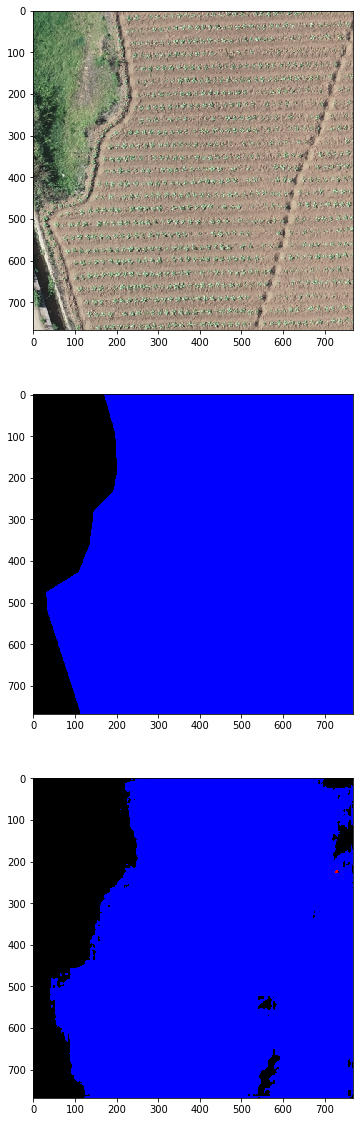

In [29]:
i=65
img = Image.open(train_path + all_imgs[i])
img = np.asarray(img)

anno_map = Image.open('D:/kaggle/nongye/jingwei_round1_train_20190619/label/' + all_imgs[i])   # 注意修改label路径
anno_map = np.asarray(anno_map)

B = anno_map.copy()   # 蓝色通道
B[B == 1] = 255
B[B == 2] = 0
B[B == 3] = 0
B[B == 0] = 0

G = anno_map.copy()   # 绿色通道
G[G == 1] = 0
G[G == 2] = 255
G[G == 3] = 0
G[G == 0] = 0

R = anno_map.copy()   # 红色通道
R[R == 1] = 0
R[R == 2] = 0
R[R == 3] = 255
R[R == 0] = 0

anno_vis = np.dstack((R,G,B))



img1 = np.expand_dims(img, axis=0)
r = model.predict(img1/255)
r = r.reshape((768, 768, 4))
r = np.argmax(r, -1)
B = r.copy()   # 蓝色通道
B[B == 1] = 255
B[B == 2] = 0
B[B == 3] = 0
B[B == 0] = 0

G = r.copy()   # 绿色通道
G[G == 1] = 0
G[G == 2] = 255
G[G == 3] = 0
G[G == 0] = 0

R = r.copy()   # 红色通道
R[R == 1] = 0
R[R == 2] = 0
R[R == 3] = 255
R[R == 0] = 0
r_vis = np.dstack((R,G,B))

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.imshow(img)

plt.subplot(3, 1, 2)
plt.imshow(anno_vis)

plt.subplot(3, 1, 3)
plt.imshow(r_vis)

plt.show()

In [25]:
r.shape

(768, 768)

In [32]:
r[:20, :20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
r1 = model.predict(img1)

In [39]:
r1[0, :5, :5, :]

array([[[1.0000000e+00, 3.2022598e-37, 1.7745910e-23, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 1.2177002e-38, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 2.8882465e-38, 1.6893071e-38]],

       [[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.00000